# PART 1: Data Loading and Preparation

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore')

import tqdm
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, MolSurf, rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

try:
    import rdkit
    print(f"RDKit version: {rdkit.__version__}")
except:
    print(f"RDKit version: Available")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

RDKit version: 2024.03.5
NumPy version: 1.24.4
Pandas version: 2.0.3


## Data Loading

In [2]:
import pandas as pd

df = pd.read_csv('./dataset/all_structures.csv', sep=',', engine='python', skiprows=1, 
                 names=['ChEMBL ID', 'Standard Value', 'Calculated pChEMBL', 'index', 'Smiles'], header=None)

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nColumn information:")
print(df.info())

Shape: (375, 5)
Columns: ['ChEMBL ID', 'Standard Value', 'Calculated pChEMBL', 'index', 'Smiles']

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ChEMBL ID           375 non-null    object 
 1   Standard Value      375 non-null    float64
 2   Calculated pChEMBL  375 non-null    float64
 3   index               375 non-null    int64  
 4   Smiles              375 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 14.8+ KB
None


In [3]:
df.head(7)

,ChEMBL ID,Standard Value,Calculated pChEMBL,index,Smiles
0,CHEMBL1173811,16100.0,4.79,600,O=C(O)c1ccccc1-c1ccccc1C(=O)Nc1cc2c3ccccc3ccc2...
1,CHEMBL1194871,330000.0,3.48,552,Clc1ccc(-c2[nH]nc3c2CNCC3)cc1
2,CHEMBL1197658,16400.0,4.79,142,Cc1cccc(Nc2nc(NCc3ccco3)c3ccccc3n2)c1
3,CHEMBL1198227,9700.0,5.01,375,Clc1cccc(Nc2nc(NCc3ccco3)c3ccccc3n2)c1
4,CHEMBL1314048,350000.0,3.46,341,Nc1nc2ccccc2n1Cc1ccc(Cl)cc1
5,CHEMBL1399619,29100.0,4.54,288,O=C1c2ccccc2C(=O)c2c1ccc(C(=O)O)c2-c1ccc2ccccc2c1
6,CHEMBL1624889,63000.0,4.20,368,Fc1ccc(CN2C3=NCCCN3c3ccccc32)cc1


## Statistics

In [4]:

print(f"Total ligands: {len(df)}")
if 'Calculated pChEMBL' in df.columns:
    print(f"  calculated pChEMBL range: {df['Calculated pChEMBL'].min():.2f} - {df['Calculated pChEMBL'].max():.2f}")
    print(f"  Calculated pChEMBL mean: {df['Calculated pChEMBL'].mean():.2f}")
    print(f"Calculated pChEMBL std: {df['Calculated pChEMBL'].std():.2f}")

Total ligands: 375
  calculated pChEMBL range: 2.72 - 9.00
  Calculated pChEMBL mean: 6.74
Calculated pChEMBL std: 1.57


In [5]:
Desc_list_func = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList)


In [6]:
Desc_list_func

## Generating Molecular Descriptors

In [7]:
from rdkit import Chem
import pandas as pd
import numpy as np

def calculate_molecular_descriptors(smiles_list):
    descriptors_list = []
    mols = []
    
    descriptor_names = Desc_list_func.GetDescriptorNames()
    
    for smi in tqdm.tqdm(smiles_list, desc="Calculating molecular descriptors"):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            descriptors_list.append({name: 0 for name in descriptor_names})
            mols.append(None)
            continue
        
        try:
            desc_values = Desc_list_func.CalcDescriptors(mol)
            desc_values = [0 if (v is None or np.isnan(v) or np.isinf(v)) else v for v in desc_values]
            desc = {name: value for name, value in zip(descriptor_names, desc_values)}
        except:
            desc = {name: 0 for name in descriptor_names}
        
        descriptors_list.append(desc)
        mols.append(mol)
    
    X = pd.DataFrame(descriptors_list)
    
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    X = X.astype(np.float64)
    
    print(f"Descriptors calculated: {X.shape}")
    print(f"Remaining invalid values - NaN: {X.isna().sum().sum()}, Inf: {np.isinf(X.values).sum()}")
    
    return X, mols

print("Molecular descriptors function loaded successfully using Desc_list_func.")

Molecular descriptors function loaded successfully using Desc_list_func.


In [8]:
X_descriptors, mols = calculate_molecular_descriptors(df['Smiles'].tolist())

Calculating molecular descriptors:   0%|          | 0/375 [00:00<?, ?it/s][10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please use MorganGenerator
[10:56:43] DEPRECATION WARNING: please us

Descriptors calculated: (375, 210)
Remaining invalid values - NaN: 0, Inf: 0


In [9]:
print(f"Molecular descriptors shape: {X_descriptors.shape}")
print(f"Number of molecules: {len(mols)}")
print(f"Number of descriptors: {X_descriptors.shape[1]}")
print(f"\nDescriptor names:")
print(list(X_descriptors.columns))
print(f"\nFirst few rows:")
X_descriptors.head()

Molecular descriptors shape: (375, 210)
Number of molecules: 375
Number of descriptors: 210

Descriptor names:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.674208,13.674208,0.153125,-1.034062,0.260374,11.111111,467.524,446.356,467.152144,172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.878284,5.878284,0.759498,0.759498,0.794169,14.812500,233.702,221.606,233.071975,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.384826,5.384826,0.561338,0.561338,0.545487,10.760000,330.391,312.247,330.148061,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.040613,6.040613,0.502696,0.502696,0.515555,10.760000,350.809,335.689,350.093439,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.956858,5.956858,0.533472,0.533472,0.765372,10.944444,257.724,245.628,257.071975,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X_valid = X_descriptors.loc[:, X_descriptors.nunique() > 1]

descriptors_to_remove = ['PEOE_VSA4', 'BCUT2D_MRHI', 'fr_alkyl_halide']
X_valid = X_valid.drop(columns=descriptors_to_remove, errors='ignore')
print("Descritores originais:", X_descriptors.shape[1])
print("Descritores após remover constantes:", X_valid.shape[1])

Descritores originais: 210
Descritores após remover constantes: 176


In [11]:
y_target = df['Calculated pChEMBL'].values

print(f"Descriptors shape: {X_valid.shape}")
print(f"Target shape: {y_target.shape}")
print(f"\nDescriptor statistics:")
X_valid.describe()

Descriptors shape: (375, 176)
Target shape: (375,)

Descriptor statistics:


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_unbrch_alkane,fr_urea
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,...,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,12.889643,12.889643,0.105396,-2.536310,0.497087,16.610033,460.526392,433.229752,460.040288,172.570667,...,0.181333,0.200000,0.013333,0.088000,0.008000,0.082667,0.032000,0.002667,0.008000,0.002667
std,1.909443,1.909443,0.136504,2.041500,0.167182,3.366067,107.431018,99.390253,107.420877,43.798819,...,0.385809,0.407155,0.154551,0.283673,0.089203,0.275746,0.176235,0.051640,0.115346,0.051640
min,3.972896,3.972896,0.000405,-4.897751,0.013012,10.470588,221.687000,209.591000,221.060742,78.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.967684,12.967684,0.034205,-4.477735,0.374788,14.571078,414.468000,389.001500,414.165729,152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.291571,13.291571,0.061128,-3.769917,0.467940,16.454545,464.013000,438.275000,463.213888,176.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.513034,13.513034,0.134030,-0.396484,0.604438,18.789474,501.553000,471.313000,501.235160,192.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.123114,15.123114,0.880629,0.880629,0.947347,31.724138,1988.275000,1845.139000,1987.041477,782.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000


# PART 2: Random Forest Model

## Model Training

In [12]:
X_clean = X_valid.copy()

X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

X_clean = X_clean.clip(lower=-1e10, upper=1e10)

print(f"STARTING NaN values: {X_clean.isna().sum().sum()}")
print(f"STARTING inf values: {np.isinf(X_clean.values).sum()}")

X_clean = X_clean.fillna(X_clean.mean())

X_clean = X_clean.astype(np.float32)

print(f"Remaining NaN values: {X_clean.isna().sum().sum()}")
print(f"Remaining inf values: {np.isinf(X_clean.values).sum()}")
print(f"Max value: {X_clean.values.max()}")
print(f"Min value: {X_clean.values.min()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean.values, 
    y_target, 
    test_size=0.2, 
    random_state=42
)

print(f"\nTraining set - NaN count: {np.isnan(X_train).sum()}, Inf count: {np.isinf(X_train).sum()}")
print(f"Test set - NaN count: {np.isnan(X_test).sum()}, Inf count: {np.isinf(X_test).sum()}")
print(f"X_train dtype: {X_train.dtype}, X_test dtype: {X_test.dtype}")

STARTING NaN values: 0
STARTING inf values: 0
Remaining NaN values: 0
Remaining inf values: 0
Max value: 10000000000.0
Min value: -26.390283584594727

Training set - NaN count: 0, Inf count: 0
Test set - NaN count: 0, Inf count: 0
X_train dtype: float32, X_test dtype: float32


In [13]:
baseline_rf = RandomForestRegressor(random_state=42)
baseline_rf.fit(X_train, y_train)

y_train_pred_baseline = baseline_rf.predict(X_train)
y_test_pred_baseline = baseline_rf.predict(X_test)

r2_train_baseline = r2_score(y_train, y_train_pred_baseline)
rmse_train_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
r2_test_baseline = r2_score(y_test, y_test_pred_baseline)
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))

print("\nBASELINE RANDOM FOREST")
print(f"{'Metric':<10} | {'TRAIN':<15} | {'TEST':<15}")
print(f"{'R²':<10} | {r2_train_baseline:<15.4f} | {r2_test_baseline:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train_baseline:<15.4f} | {rmse_test_baseline:<15.4f}")


BASELINE RANDOM FOREST
Metric     | TRAIN           | TEST           
R²         | 0.9832          | 0.8914         
RMSE       | 0.2048          | 0.4881         


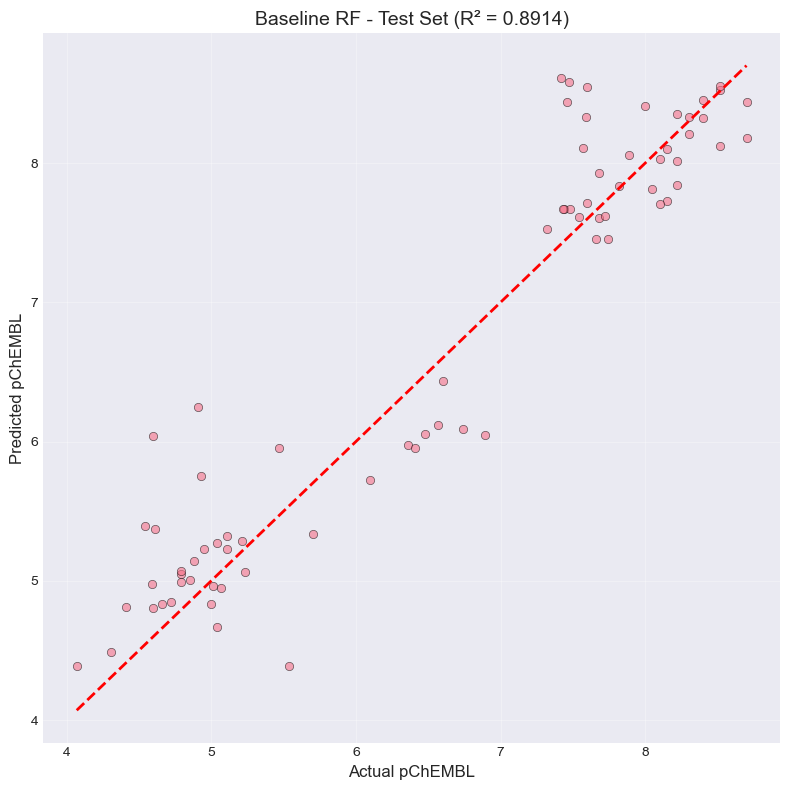

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_baseline, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pChEMBL', fontsize=12)
plt.ylabel('Predicted pChEMBL', fontsize=12)
plt.title(f'Baseline RF - Test Set (R² = {r2_test_baseline:.4f})', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use the cleaned data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean.values, 
    y_target, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of descriptors: {X_train.shape[1]}")

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_search.fit(X_train, y_train)

Training set size: 300 samples
Test set size: 75 samples
Number of descriptors: 176
Fitting 15 folds for each of 100 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='r2', verbose=1)

In [16]:
print(rand_search.best_params_)
print(f"\nMelhor R² médio (validação cruzada): {rand_search.best_score_:.4f}")

best_rf = rand_search.best_estimator_

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}

Melhor R² médio (validação cruzada): 0.9081


In [17]:
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"{'Métrica':<10} | {'TREINO':<15} | {'TESTE':<15}")
print(f"{'R²':<10} | {r2_train:<15.4f} | {r2_test:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train:<15.4f} | {rmse_test:<15.4f}")
print(f"{'MAE':<10} | {mae_train:<15.4f} | {mae_test:<15.4f}")

Métrica    | TREINO          | TESTE          
R²         | 0.9922          | 0.8918         
RMSE       | 0.1398          | 0.4872         
MAE        | 0.0918          | 0.3561         


## Final Model Training

In [18]:
final_model = RandomForestRegressor(random_state=42, n_jobs=-1)

best_params = rand_search.best_params_
final_model.set_params(**best_params)

print("Hyperparameters used in final model:")
print(final_model.get_params())

X_combined = X_clean.values
y_combined = y_target

final_model.fit(X_combined, y_combined)

print(f"\nFinal model trained on {X_clean.shape[0]} samples with {X_clean.shape[1]} descriptors.")

Hyperparameters used in final model:
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Final model trained on 375 samples with 176 descriptors.


## Final Performance

In [19]:
y_total_pred = final_model.predict(X_clean.values)
train_r2_final = r2_score(y_target, y_total_pred)
train_rmse_final = np.sqrt(mean_squared_error(y_target, y_total_pred))

print(f"Total R2 (100% training): {train_r2_final:.4f}")
print(f"Total RMSE (100% training): {train_rmse_final:.4f}")

Total R2 (100% training): 0.9889
Total RMSE (100% training): 0.1645


## Random Forest - SHAP Analysis

In [20]:
import shap

explainer = shap.TreeExplainer(final_model)

print(f"Number of test samples: {len(X_test)}")

shap_values = explainer.shap_values(X_test, check_additivity=False)
expected_value = explainer.expected_value

print(f"SHAP values computed")
print(f"Shape: {shap_values.shape}")

if isinstance(expected_value, np.ndarray):
    ev_display = expected_value[0] if len(expected_value) > 0 else expected_value
else:
    ev_display = expected_value
print(f"Expected value (baseline): {ev_display:.4f}")

mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = list(X_valid.columns)

Number of test samples: 75
SHAP values computed
Shape: (75, 176)
Expected value (baseline): 6.7373


### SHAP importance DF

In [21]:
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)
shap_importance

,feature,mean_abs_shap
73,SlogP_VSA5,0.140592
144,fr_aryl_methyl,0.100386
69,SlogP_VSA12,0.084343
52,PEOE_VSA3,0.073148
17,BCUT2D_MWHI,0.068956
...,...,...
137,fr_N_O,0.000005
172,fr_sulfone,0.000004
158,fr_nitrile,0.000003
162,fr_oxazole,0.000003


### Top 10 Important Features

In [22]:
shap_importance.head(10)

,feature,mean_abs_shap
73,SlogP_VSA5,0.140592
144,fr_aryl_methyl,0.100386
69,SlogP_VSA12,0.084343
52,PEOE_VSA3,0.073148
17,BCUT2D_MWHI,0.068956
46,PEOE_VSA10,0.064037
28,Chi0n,0.064005
13,MinAbsPartialCharge,0.059353
41,Kappa1,0.051741
117,MolLogP,0.047161


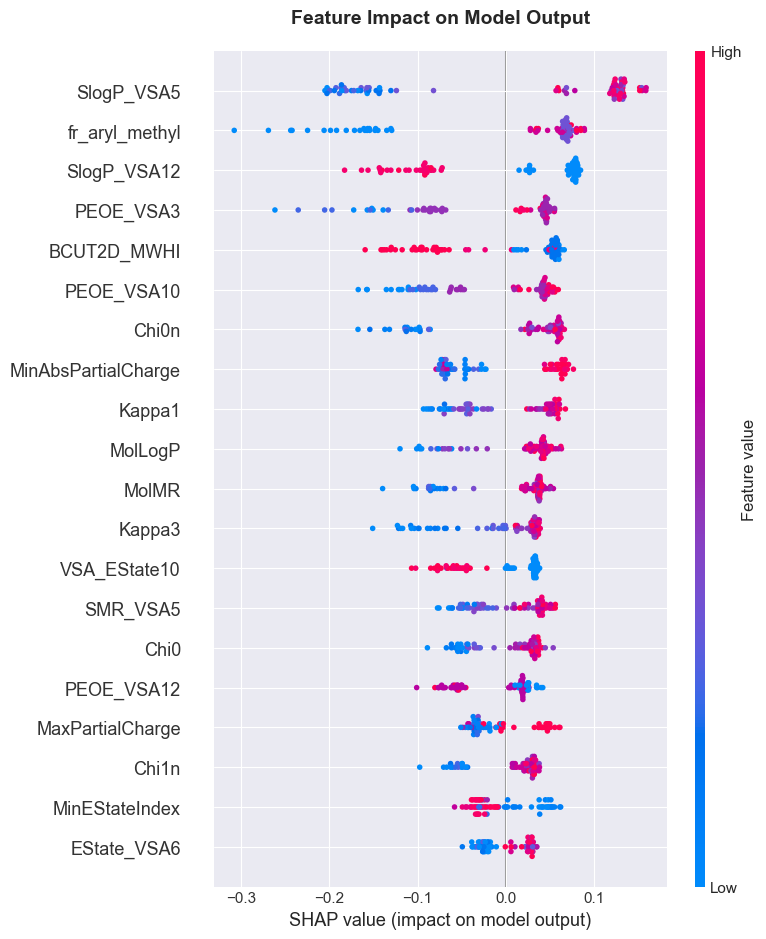

SHAP beeswarm plot saved as 'shap_beeswarm_rf.png'


In [24]:
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                  plot_type="dot", show=False, max_display=20)
plt.title('Feature Impact on Model Output', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_beeswarm_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP beeswarm plot saved as 'shap_beeswarm_rf.png'")

Creating SHAP bar plot...


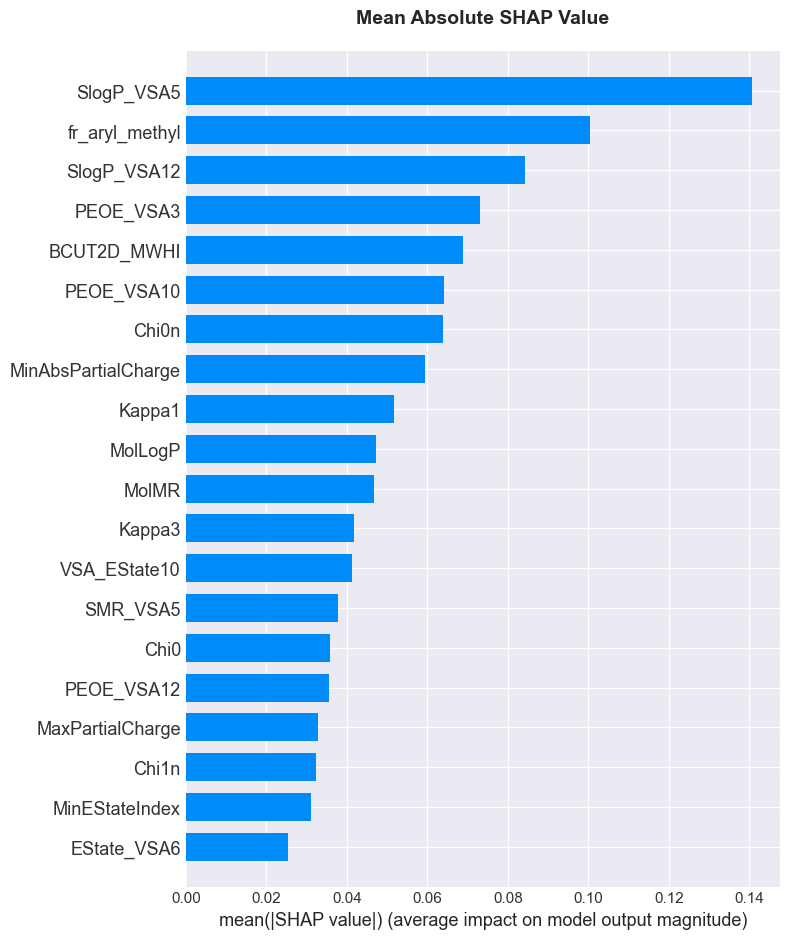

SHAP bar plot saved as 'shap_bar_rf.png'


In [25]:
print("Creating SHAP bar plot...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                  plot_type="bar", show=False, max_display=20)
plt.title('Mean Absolute SHAP Value', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_bar_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP bar plot saved as 'shap_bar_rf.png'")

Creating feature interaction heatmap...


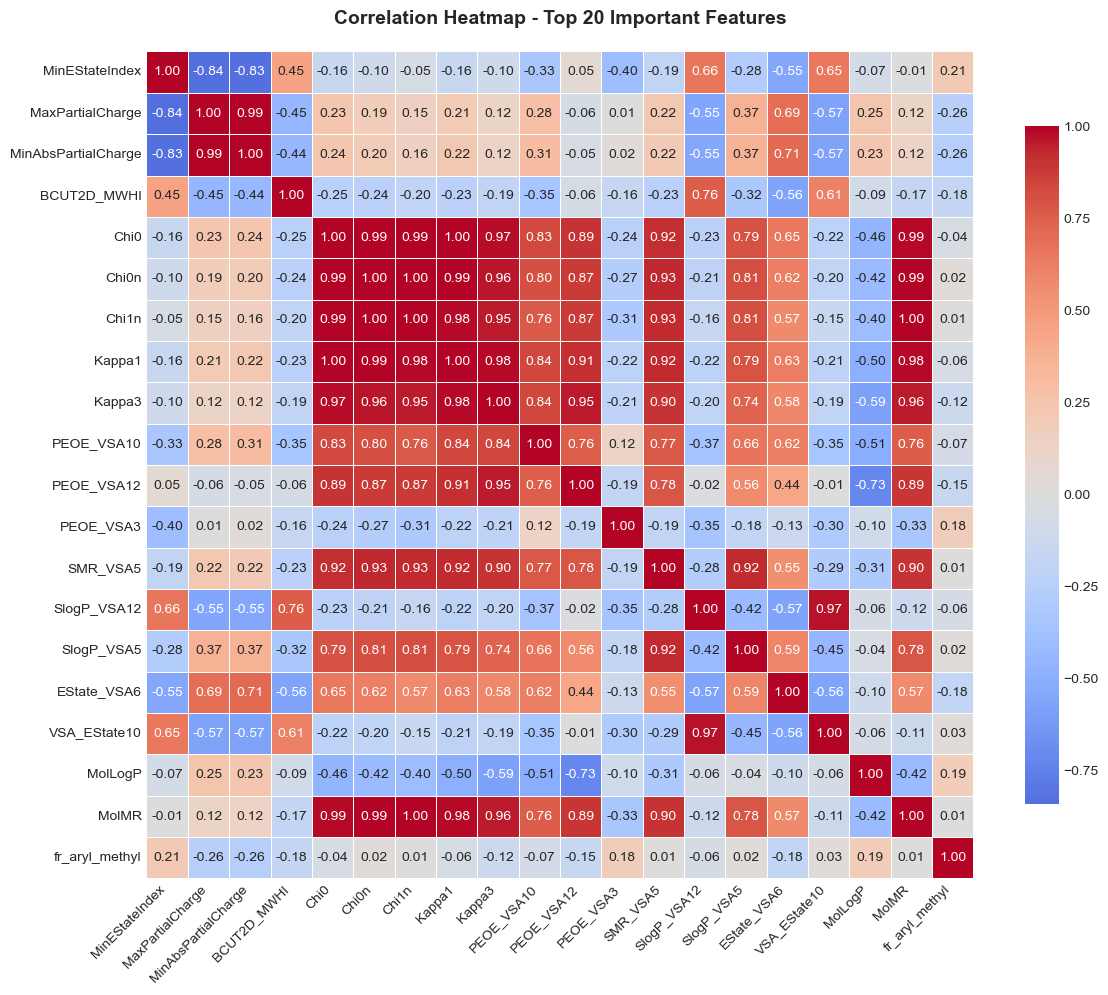

Feature interaction heatmap saved as 'feature_interaction_heatmap_rf.png'


In [26]:
print("Creating feature interaction heatmap...")

top_n_features = 20
top_features_idx = shap_importance.head(top_n_features).index.tolist()
top_features_names = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] in shap_importance.head(top_n_features)['feature'].values]

top_features_columns = [i for i, name in enumerate(feature_names) if name in top_features_names]

X_test_df = pd.DataFrame(X_test, columns=feature_names)
top_features_data = X_test_df[top_features_names]
correlation_matrix = top_features_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f'Correlation Heatmap - Top {top_n_features} Important Features', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/feature_interaction_heatmap_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Feature interaction heatmap saved as 'feature_interaction_heatmap_rf.png'")

Creating SHAP interaction heatmap for Random Forest...


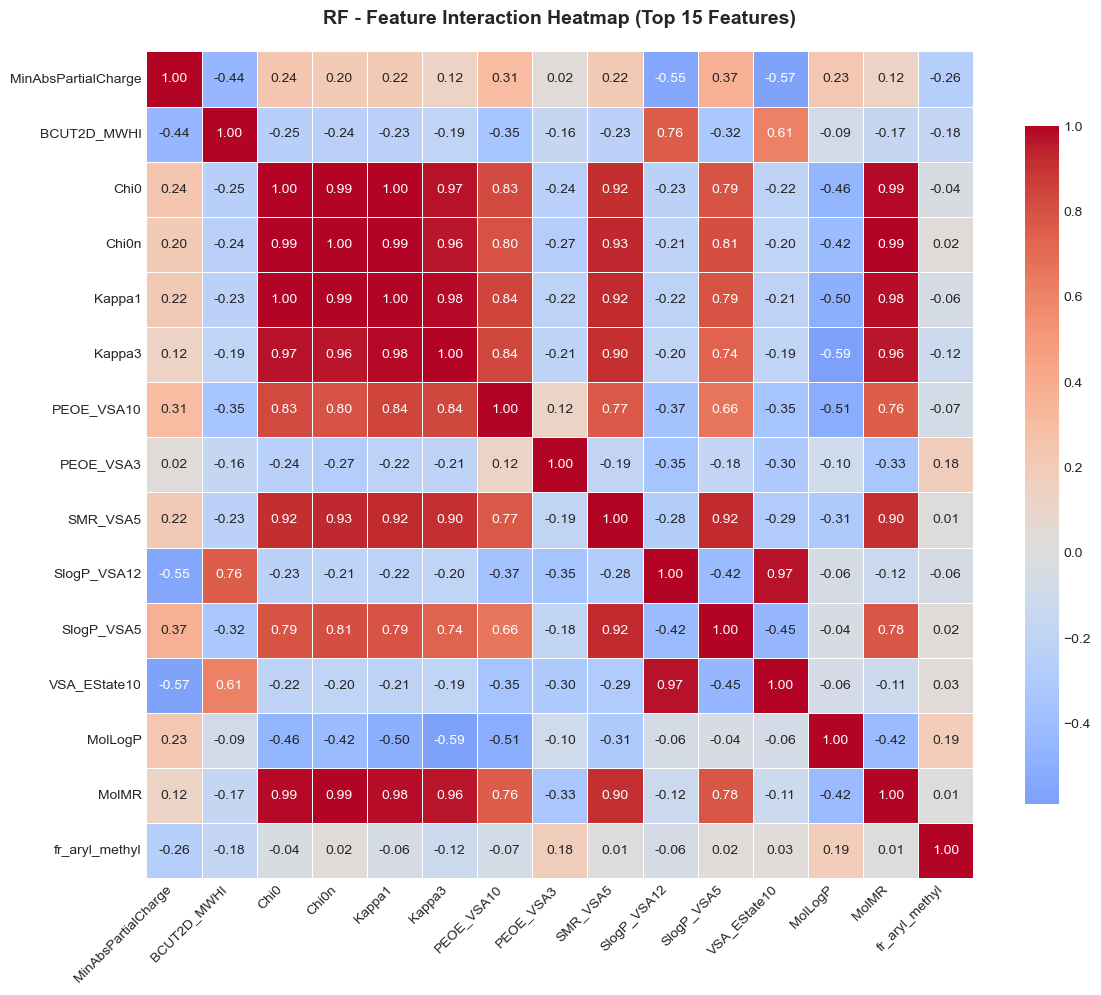

SHAP interaction heatmap saved as 'shap_interaction_heatmap_rf.png'


In [27]:
print("Creating SHAP interaction heatmap for Random Forest...")

top_n_features = 15
top_features_idx = shap_importance.head(top_n_features).index.tolist()
top_features_names_rf = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] in shap_importance.head(top_n_features)['feature'].values]

top_features_columns_rf = [i for i, name in enumerate(feature_names) if name in top_features_names_rf]

X_test_df = pd.DataFrame(X_test, columns=feature_names)
top_features_data_rf = X_test_df[top_features_names_rf]
correlation_matrix_rf = top_features_data_rf.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_rf, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f'RF - Feature Interaction Heatmap (Top {top_n_features} Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/shap_interaction_heatmap_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"SHAP interaction heatmap saved as 'shap_interaction_heatmap_rf.png'")

Creating SHAP waterfall plot for a sample prediction...


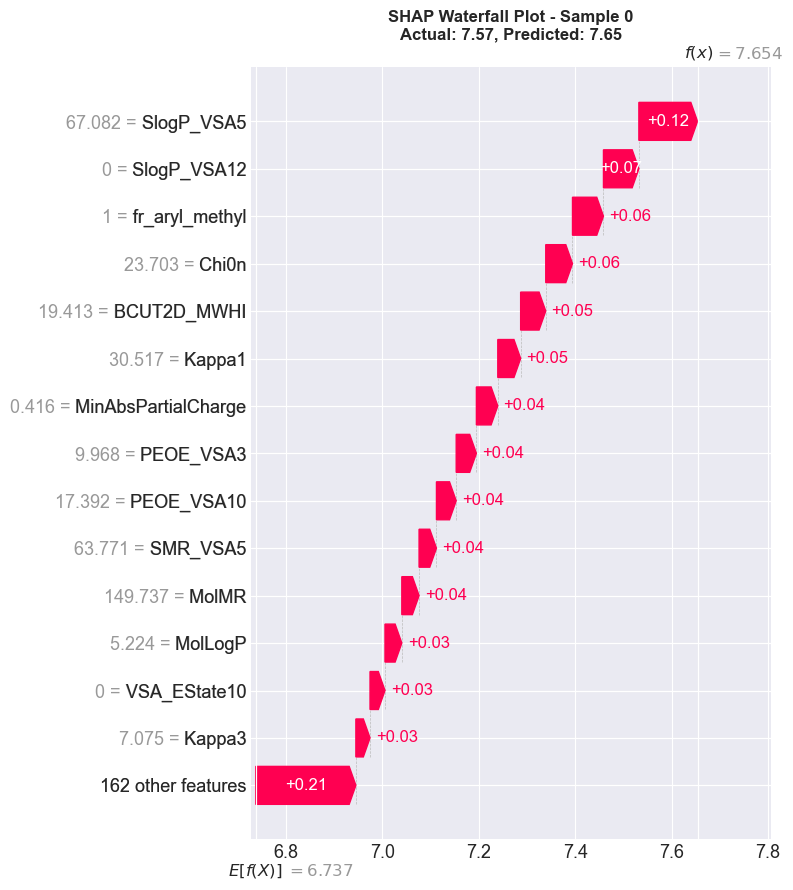

Waterfall plot for sample 0 saved as 'shap_waterfall_rf.png'
SHAP f(x) = 7.654 (should match 'Predicted' in title)


In [28]:
print("Creating SHAP waterfall plot for a sample prediction...")

sample_idx = 0

sample_prediction = final_model.predict(X_test[sample_idx].reshape(1, -1))[0]

sample_explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=expected_value,
    data=X_test[sample_idx],
    feature_names=feature_names
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(sample_explanation, max_display=15, show=False)
plt.title(f'SHAP Waterfall Plot - Sample {sample_idx}\nActual: {y_test[sample_idx]:.2f}, Predicted: {sample_prediction:.2f}', 
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_waterfall_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Waterfall plot for sample {sample_idx} saved as 'shap_waterfall_rf.png'")
print(f"SHAP f(x) = {sample_prediction:.3f} (should match 'Predicted' in title)")

Creating residual plot...


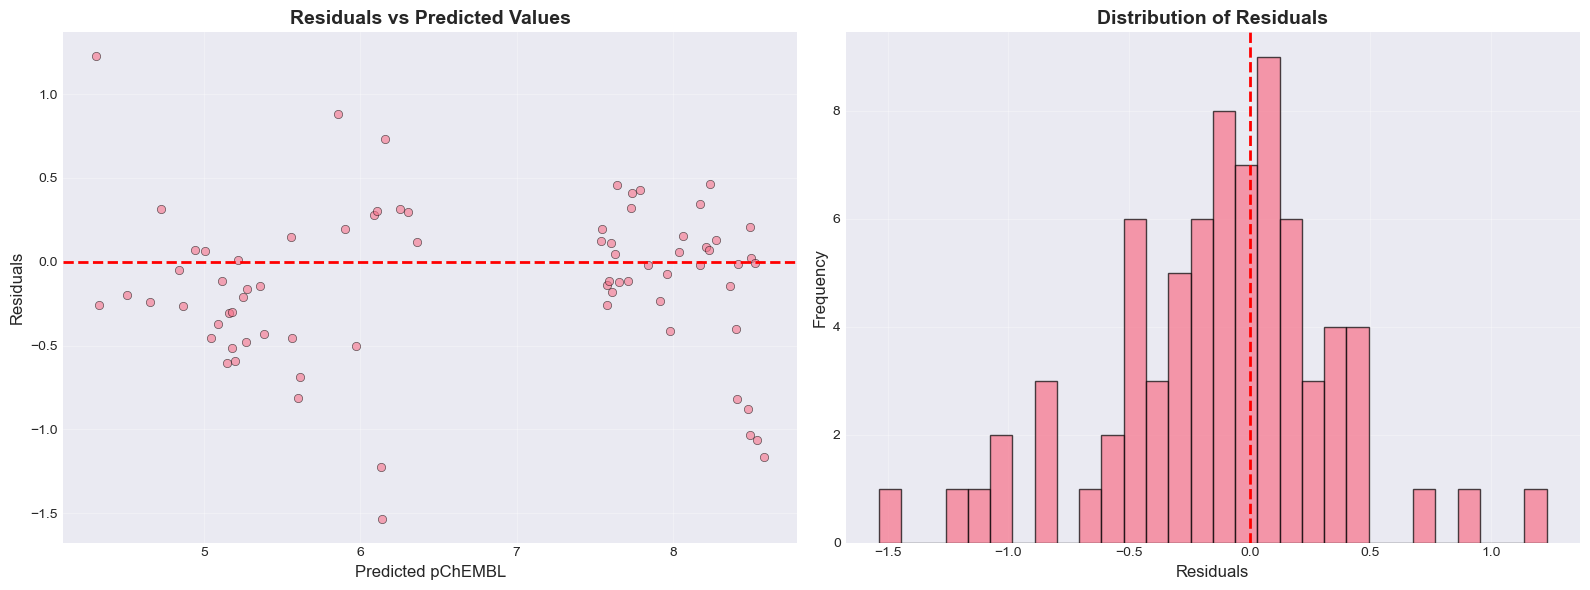

Mean residual: -0.1268
Std residual: 0.4704
Residual plot saved as 'residual_plot_rf.png'


In [29]:
print("Creating residual plot...")

residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted pChEMBL', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./images/residual_plot_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Mean residual: {residuals.mean():.4f}")
print(f"Std residual: {residuals.std():.4f}")
print("Residual plot saved as 'residual_plot_rf.png'")

In [30]:
from scipy.stats import shapiro


print("\nH0: Os resíduos seguem uma distribuição normal")
print("H1: Os resíduos NÃO seguem uma distribuição normal")
print("Nível de significância: α = 0.05")
print("\n" + "="*80)

residuals_rf = y_test - y_test_pred


stat_rf, p_rf = shapiro(residuals_rf)


print("\n1. RANDOM FOREST:")
print(f"Estatística W: {stat_rf:.6f}")
print(f"p-valor: {p_rf:.6e}")
print(f"Resultado: {'REJEITA H0 → Resíduos NÃO são normais' if p_rf < 0.05 else 'NÃO rejeita H0 → Resíduos são normais'}")
print(f"N resíduos: {len(residuals_rf)}")


print("INTERPRETAÇÃO:")

print("- Estatística W próxima de 1 indica distribuição mais próxima da normal")
print("- p-valor < 0.05: Evidência significativa CONTRA normalidade")
print("- p-valor ≥ 0.05: Não há evidência suficiente para rejeitar normalidade")



H0: Os resíduos seguem uma distribuição normal
H1: Os resíduos NÃO seguem uma distribuição normal
Nível de significância: α = 0.05


1. RANDOM FOREST:
Estatística W: 0.971249
p-valor: 8.553477e-02
Resultado: NÃO rejeita H0 → Resíduos são normais
N resíduos: 75
INTERPRETAÇÃO:
- Estatística W próxima de 1 indica distribuição mais próxima da normal
- p-valor < 0.05: Evidência significativa CONTRA normalidade
- p-valor ≥ 0.05: Não há evidência suficiente para rejeitar normalidade


### Teste de Normalidade dos Resíduos (Shapiro-Wilk)

### SHAP Loss

Analysis Context: Random Forest Regressor
Threshold for 'Bad' predictions: Error > 0.5648
Analyzing the 4 worst samples out of 75


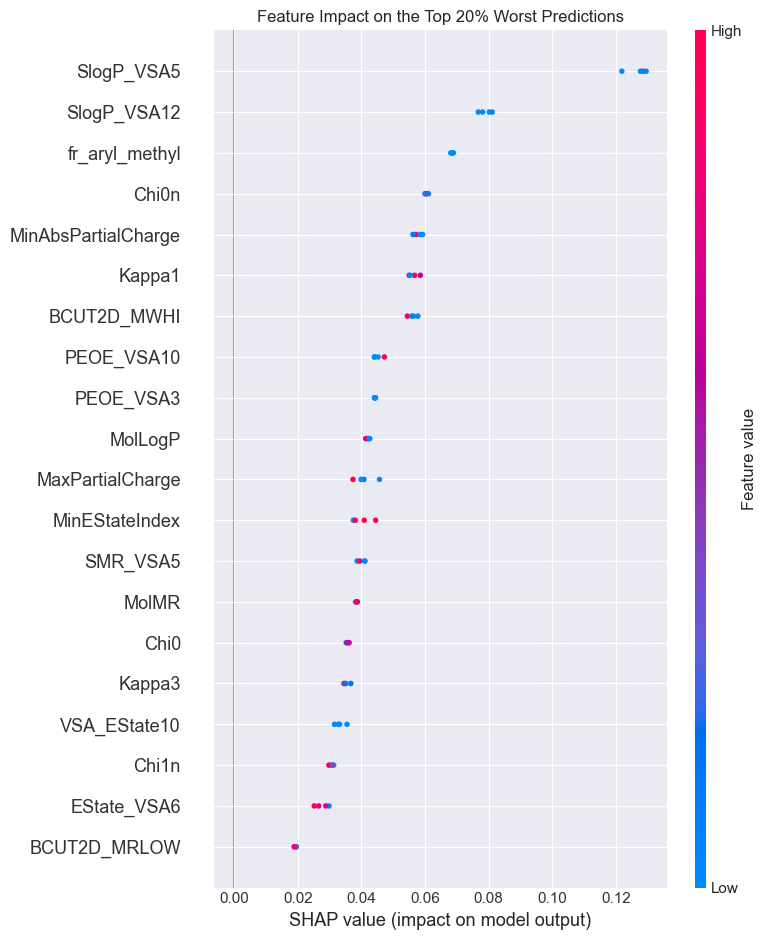

In [31]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test, check_additivity=False)

predictions = final_model.predict(X_test)
residuals = np.abs(y_test - predictions)

threshold = np.percentile(residuals, 95) 
high_error_mask = residuals > threshold

print(f"Analysis Context: Random Forest Regressor")
print(f"Threshold for 'Bad' predictions: Error > {threshold:.4f}")
print(f"Analyzing the {np.sum(high_error_mask)} worst samples out of {len(X_test)}")

shap_values_worst = shap_values[high_error_mask]
X_test_worst = X_test[high_error_mask]

plt.figure(figsize=(10, 6))
plt.title("Feature Impact on the Top 20% Worst Predictions")
shap.summary_plot(
    shap_values_worst, 
    X_test_worst, 
    feature_names=feature_names
)

# PART 3: Decision Tree Model

## Decision Tree - Baseline Model

In [32]:
from sklearn.tree import DecisionTreeRegressor

baseline_dt = DecisionTreeRegressor(
    random_state=42
)
baseline_dt.fit(X_train, y_train)

y_train_pred_baseline_dt = baseline_dt.predict(X_train)
y_test_pred_baseline_dt = baseline_dt.predict(X_test)

r2_train_baseline_dt = r2_score(y_train, y_train_pred_baseline_dt)
rmse_train_baseline_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline_dt))
r2_test_baseline_dt = r2_score(y_test, y_test_pred_baseline_dt)
rmse_test_baseline_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline_dt))

print("\nBASELINE DECISION TREE")
print(f"{'Metric':<10} | {'TRAIN':<15} | {'TEST':<15}")
print(f"{'R²':<10} | {r2_train_baseline_dt:<15.4f} | {r2_test_baseline_dt:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train_baseline_dt:<15.4f} | {rmse_test_baseline_dt:<15.4f}")


BASELINE DECISION TREE
Metric     | TRAIN           | TEST           
R²         | 0.9949          | 0.7942         
RMSE       | 0.1125          | 0.6719         


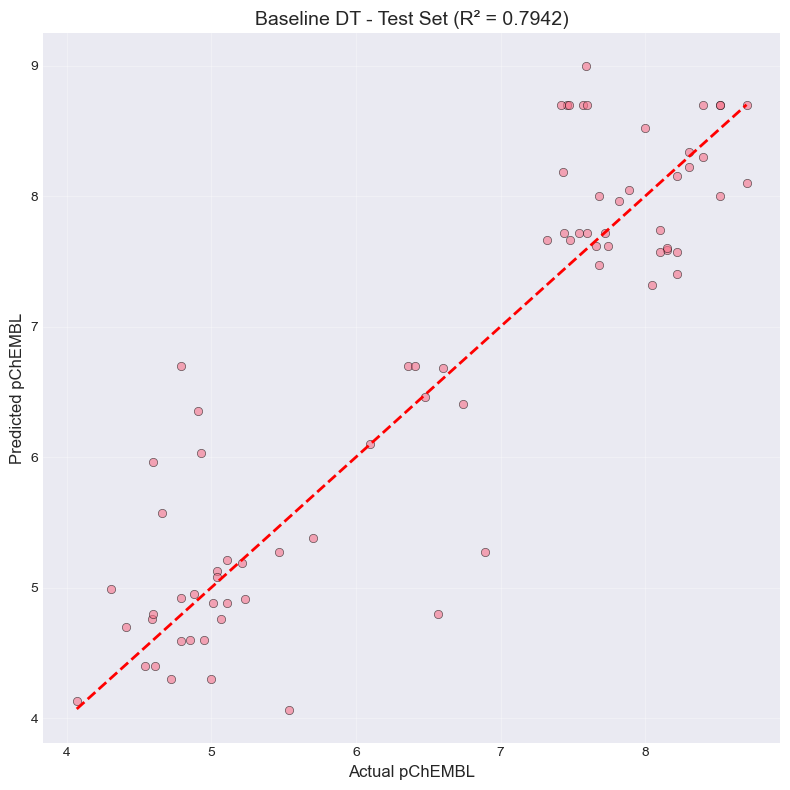

In [33]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_baseline_dt, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pChEMBL', fontsize=12)
plt.ylabel('Predicted pChEMBL', fontsize=12)
plt.title(f'Baseline DT - Test Set (R² = {r2_test_baseline_dt:.4f})', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Decision Tree - Hyperparameter Optimization

In [34]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

Fitting 15 folds for each of 240 candidates, totalling 3600 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='r2', verbose=1)

In [35]:
print("Best parameters for Decision Tree:")
print(grid_search_dt.best_params_)
print(f"\nBest R² (cross-validation): {grid_search_dt.best_score_:.4f}")

best_dt = grid_search_dt.best_estimator_

Best parameters for Decision Tree:
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Best R² (cross-validation): 0.8675


## Decision Tree - Model Evaluation

In [36]:
y_train_pred_dt = best_dt.predict(X_train)
y_test_pred_dt = best_dt.predict(X_test)

r2_train_dt = r2_score(y_train, y_train_pred_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
mae_train_dt = mean_absolute_error(y_train, y_train_pred_dt)

r2_test_dt = r2_score(y_test, y_test_pred_dt)
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
mae_test_dt = mean_absolute_error(y_test, y_test_pred_dt)

print(f"{'Métrica':<10} | {'TREINO':<15} | {'TESTE':<15}")
print(f"{'R²':<10} | {r2_train_dt:<15.4f} | {r2_test_dt:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train_dt:<15.4f} | {rmse_test_dt:<15.4f}")
print(f"{'MAE':<10} | {mae_train_dt:<15.4f} | {mae_test_dt:<15.4f}")

Métrica    | TREINO          | TESTE          
R²         | 0.9665          | 0.8218         
RMSE       | 0.2892          | 0.6252         
MAE        | 0.2264          | 0.4323         


## Decision Tree - Final Model Training

In [37]:
final_model_dt = DecisionTreeRegressor(random_state=42)

best_params_dt = grid_search_dt.best_params_
final_model_dt.set_params(**best_params_dt)

print("Hyperparameters used in final Decision Tree model:")
print(final_model_dt.get_params())

X_combined = X_clean.values
y_combined = y_target

final_model_dt.fit(X_combined, y_combined)

print(f"\nFinal DT model trained on {X_clean.shape[0]} samples with {X_clean.shape[1]} descriptors.")

Hyperparameters used in final Decision Tree model:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

Final DT model trained on 375 samples with 176 descriptors.


In [38]:
y_total_pred_dt = final_model_dt.predict(X_clean.values)
train_r2_final_dt = r2_score(y_target, y_total_pred_dt)
train_rmse_final_dt = np.sqrt(mean_squared_error(y_target, y_total_pred_dt))

print(f"Total R2 (100% training - DT): {train_r2_final_dt:.4f}")
print(f"Total RMSE (100% training - DT): {train_rmse_final_dt:.4f}")

Total R2 (100% training - DT): 0.9595
Total RMSE (100% training - DT): 0.3147


## Decision Tree - SHAP Analysis

In [39]:
explainer_dt = shap.TreeExplainer(final_model_dt)

print(f"Number of test samples: {len(X_test)}")

shap_values_dt = explainer_dt.shap_values(X_test, check_additivity=False)
expected_value_dt = explainer_dt.expected_value

print(f"SHAP values computed for Decision Tree")
print(f"Shape: {shap_values_dt.shape}")

if isinstance(expected_value_dt, np.ndarray):
    ev_display_dt = expected_value_dt[0] if len(expected_value_dt) > 0 else expected_value_dt
else:
    ev_display_dt = expected_value_dt
print(f"Expected value (baseline): {ev_display_dt:.4f}")

mean_abs_shap_dt = np.abs(shap_values_dt).mean(axis=0)
feature_names = list(X_valid.columns)

Number of test samples: 75
SHAP values computed for Decision Tree
Shape: (75, 176)
Expected value (baseline): 6.7373


In [40]:
shap_importance_dt = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap_dt
}).sort_values('mean_abs_shap', ascending=False)

print("Top 10 Important Features - Decision Tree:")
shap_importance_dt.head(10)

Top 10 Important Features - Decision Tree:


,feature,mean_abs_shap
73,SlogP_VSA5,0.851034
52,PEOE_VSA3,0.383546
48,PEOE_VSA12,0.287755
90,VSA_EState10,0.167232
95,VSA_EState6,0.118329
10,MaxPartialCharge,0.061750
107,NumAromaticHeterocycles,0.053351
63,SMR_VSA6,0.045840
20,BCUT2D_CHGLO,0.041258
6,MolWt,0.035568


Creating SHAP beeswarm plot for Decision Tree...


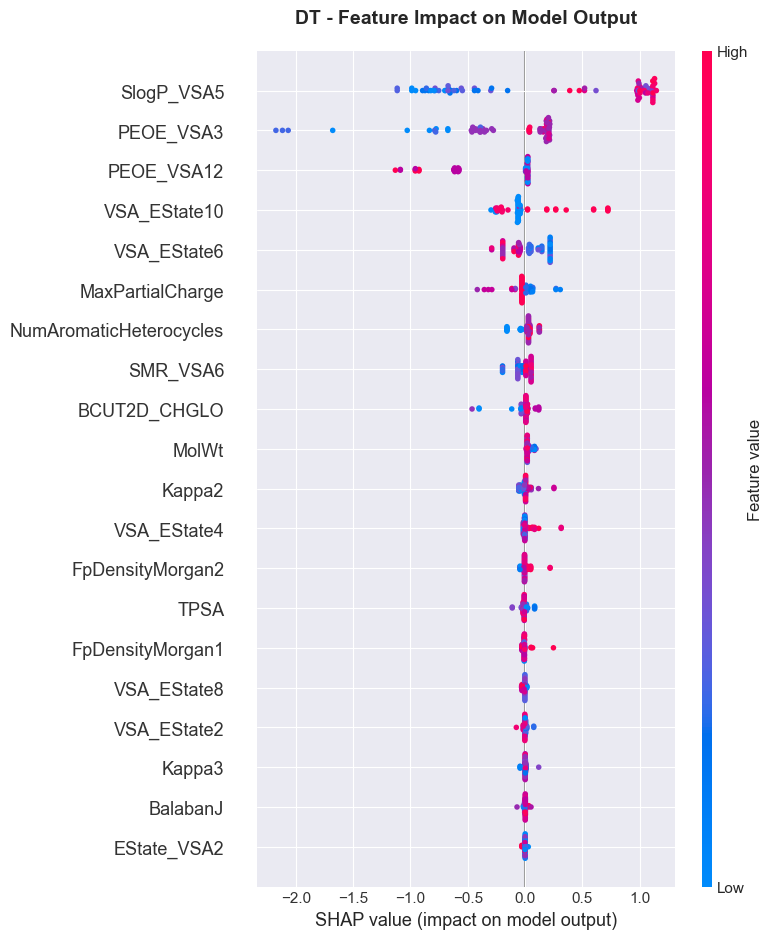

SHAP beeswarm plot saved as 'shap_beeswarm_dt.png'


In [41]:
print("Creating SHAP beeswarm plot for Decision Tree...")

plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values_dt, X_test, feature_names=feature_names,
                  plot_type="dot", show=False, max_display=20)
plt.title('DT - Feature Impact on Model Output', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_beeswarm_dt.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP beeswarm plot saved as 'shap_beeswarm_dt.png'")

Creating SHAP bar plot for Decision Tree...


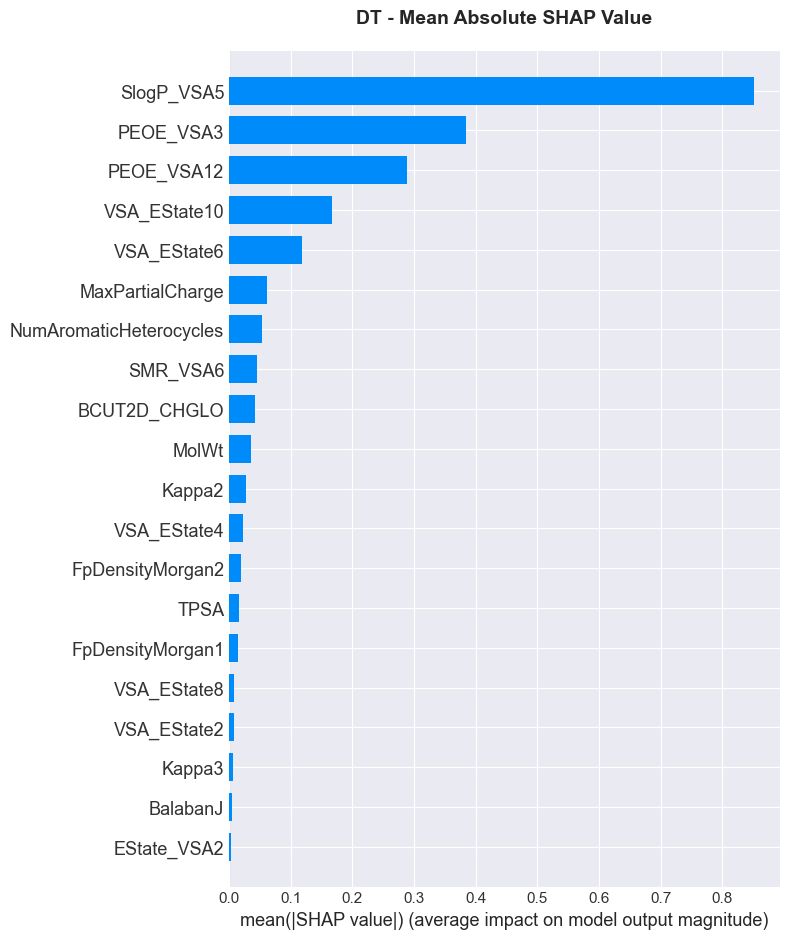

SHAP bar plot saved as 'shap_bar_dt.png'


In [42]:
print("Creating SHAP bar plot for Decision Tree...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dt, X_test, feature_names=feature_names,
                  plot_type="bar", show=False, max_display=20)
plt.title('DT - Mean Absolute SHAP Value', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_bar_dt.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP bar plot saved as 'shap_bar_dt.png'")

Creating SHAP interaction heatmap for Decision Tree...


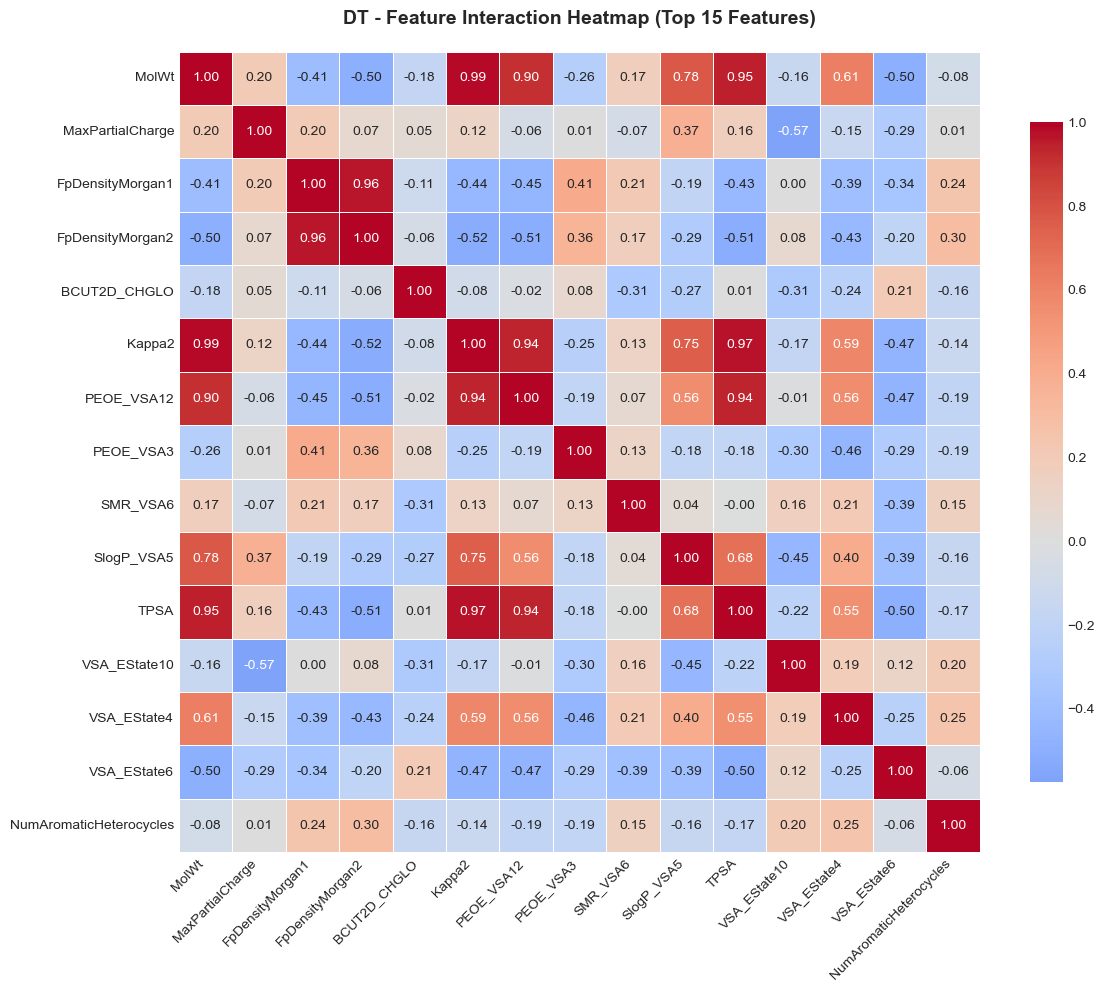

SHAP interaction heatmap saved as 'shap_interaction_heatmap_dt.png'


In [43]:
print("Creating SHAP interaction heatmap for Decision Tree...")

top_n_features_dt = 15
top_features_names_dt = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] in shap_importance_dt.head(top_n_features_dt)['feature'].values]

X_test_df = pd.DataFrame(X_test, columns=feature_names)
top_features_data_dt = X_test_df[top_features_names_dt]
correlation_matrix_dt = top_features_data_dt.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_dt, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f'DT - Feature Interaction Heatmap (Top {top_n_features_dt} Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/shap_interaction_heatmap_dt.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"SHAP interaction heatmap saved as 'shap_interaction_heatmap_dt.png'")

# PART 4: LightGBM Model

## LightGBM - Baseline Model

In [44]:
import lightgbm as lgb

baseline_lgbm = lgb.LGBMRegressor(
    random_state=42,
    verbose=-1
)
baseline_lgbm.fit(X_train, y_train)

y_train_pred_baseline_lgbm = baseline_lgbm.predict(X_train)
y_test_pred_baseline_lgbm = baseline_lgbm.predict(X_test)

r2_train_baseline_lgbm = r2_score(y_train, y_train_pred_baseline_lgbm)
rmse_train_baseline_lgbm = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline_lgbm))
r2_test_baseline_lgbm = r2_score(y_test, y_test_pred_baseline_lgbm)
rmse_test_baseline_lgbm = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline_lgbm))

print("\nBASELINE LIGHTGBM")
print(f"{'Metric':<10} | {'TRAIN':<15} | {'TEST':<15}")
print(f"{'R²':<10} | {r2_train_baseline_lgbm:<15.4f} | {r2_test_baseline_lgbm:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train_baseline_lgbm:<15.4f} | {rmse_test_baseline_lgbm:<15.4f}")


BASELINE LIGHTGBM
Metric     | TRAIN           | TEST           
R²         | 0.9893          | 0.8002         
RMSE       | 0.1637          | 0.6620         


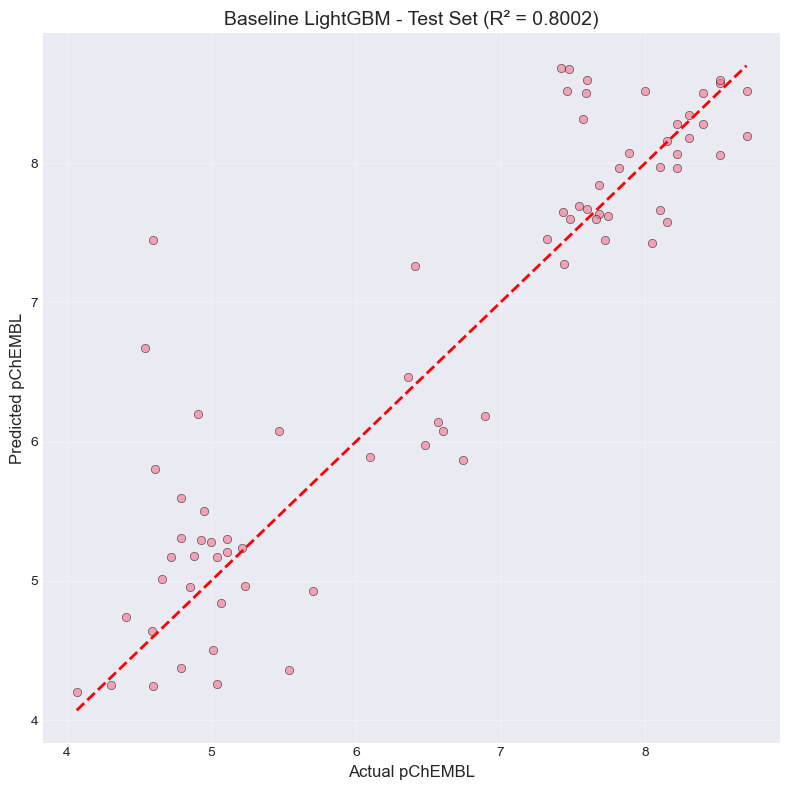

In [45]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_baseline_lgbm, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pChEMBL', fontsize=12)
plt.ylabel('Predicted pChEMBL', fontsize=12)
plt.title(f'Baseline LightGBM - Test Set (R² = {r2_test_baseline_lgbm:.4f})', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## LightGBM - Hyperparameter Optimization

In [46]:
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)

param_distributions_lgbm = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [5, 10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

rand_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions_lgbm,
    n_iter=100,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_search_lgbm.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=LGBMRegressor(random_state=42, verbose=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [5, 10, 15, 20, -1],
                                        'min_child_samples': [5, 10, 20, 30],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [15, 31, 63, 127],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [47]:
print("Best parameters for LightGBM:")
print(rand_search_lgbm.best_params_)
print(f"\nBest R² (cross-validation): {rand_search_lgbm.best_score_:.4f}")

best_lgbm = rand_search_lgbm.best_estimator_

Best parameters for LightGBM:
{'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 300, 'min_child_samples': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

Best R² (cross-validation): 0.9031


## LightGBM - Model Evaluation

In [48]:
y_train_pred_lgbm = best_lgbm.predict(X_train)
y_test_pred_lgbm = best_lgbm.predict(X_test)

r2_train_lgbm = r2_score(y_train, y_train_pred_lgbm)
rmse_train_lgbm = np.sqrt(mean_squared_error(y_train, y_train_pred_lgbm))
mae_train_lgbm = mean_absolute_error(y_train, y_train_pred_lgbm)

r2_test_lgbm = r2_score(y_test, y_test_pred_lgbm)
rmse_test_lgbm = np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm))
mae_test_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm)

print(f"{'Métrica':<10} | {'TREINO':<15} | {'TESTE':<15}")
print(f"{'R²':<10} | {r2_train_lgbm:<15.4f} | {r2_test_lgbm:<15.4f}")
print(f"{'RMSE':<10} | {rmse_train_lgbm:<15.4f} | {rmse_test_lgbm:<15.4f}")
print(f"{'MAE':<10} | {mae_train_lgbm:<15.4f} | {mae_test_lgbm:<15.4f}")

Métrica    | TREINO          | TESTE          
R²         | 0.9947          | 0.8714         
RMSE       | 0.1152          | 0.5311         
MAE        | 0.0493          | 0.3954         


## LightGBM - Final Model Training

In [49]:
final_model_lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)

best_params_lgbm = rand_search_lgbm.best_params_
final_model_lgbm.set_params(**best_params_lgbm)

print("Hyperparameters used in final LightGBM model:")
print(final_model_lgbm.get_params())

X_combined = X_clean.values
y_combined = y_target

final_model_lgbm.fit(X_combined, y_combined)

print(f"\nFinal LightGBM model trained on {X_clean.shape[0]} samples with {X_clean.shape[1]} descriptors.")

Hyperparameters used in final LightGBM model:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves': 127, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}

Final LightGBM model trained on 375 samples with 176 descriptors.


In [50]:
y_total_pred_lgbm = final_model_lgbm.predict(X_clean.values)
train_r2_final_lgbm = r2_score(y_target, y_total_pred_lgbm)
train_rmse_final_lgbm = np.sqrt(mean_squared_error(y_target, y_total_pred_lgbm))

print(f"Total R2 (100% training - LightGBM): {train_r2_final_lgbm:.4f}")
print(f"Total RMSE (100% training - LightGBM): {train_rmse_final_lgbm:.4f}")

Total R2 (100% training - LightGBM): 0.9915
Total RMSE (100% training - LightGBM): 0.1438


## LightGBM - SHAP Analysis

In [51]:
explainer_lgbm = shap.TreeExplainer(final_model_lgbm)

print(f"Number of test samples: {len(X_test)}")

shap_values_lgbm = explainer_lgbm.shap_values(X_test, check_additivity=False)
expected_value_lgbm = explainer_lgbm.expected_value

print(f"SHAP values computed for LightGBM")
print(f"Shape: {shap_values_lgbm.shape}")

if isinstance(expected_value_lgbm, np.ndarray):
    ev_display_lgbm = expected_value_lgbm[0] if len(expected_value_lgbm) > 0 else expected_value_lgbm
else:
    ev_display_lgbm = expected_value_lgbm
print(f"Expected value (baseline): {ev_display_lgbm:.4f}")

mean_abs_shap_lgbm = np.abs(shap_values_lgbm).mean(axis=0)
feature_names = list(X_valid.columns)

Number of test samples: 75
SHAP values computed for LightGBM
Shape: (75, 176)
Expected value (baseline): 6.7373


In [52]:
shap_importance_lgbm = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap_lgbm
}).sort_values('mean_abs_shap', ascending=False)

print("Top 10 Important Features - LightGBM:")
shap_importance_lgbm.head(10)

Top 10 Important Features - LightGBM:


,feature,mean_abs_shap
73,SlogP_VSA5,0.570793
52,PEOE_VSA3,0.208669
144,fr_aryl_methyl,0.207459
28,Chi0n,0.084300
90,VSA_EState10,0.066021
117,MolLogP,0.050159
46,PEOE_VSA10,0.049139
48,PEOE_VSA12,0.044967
41,Kappa1,0.043659
11,MinPartialCharge,0.043452


Creating SHAP beeswarm plot for LightGBM...


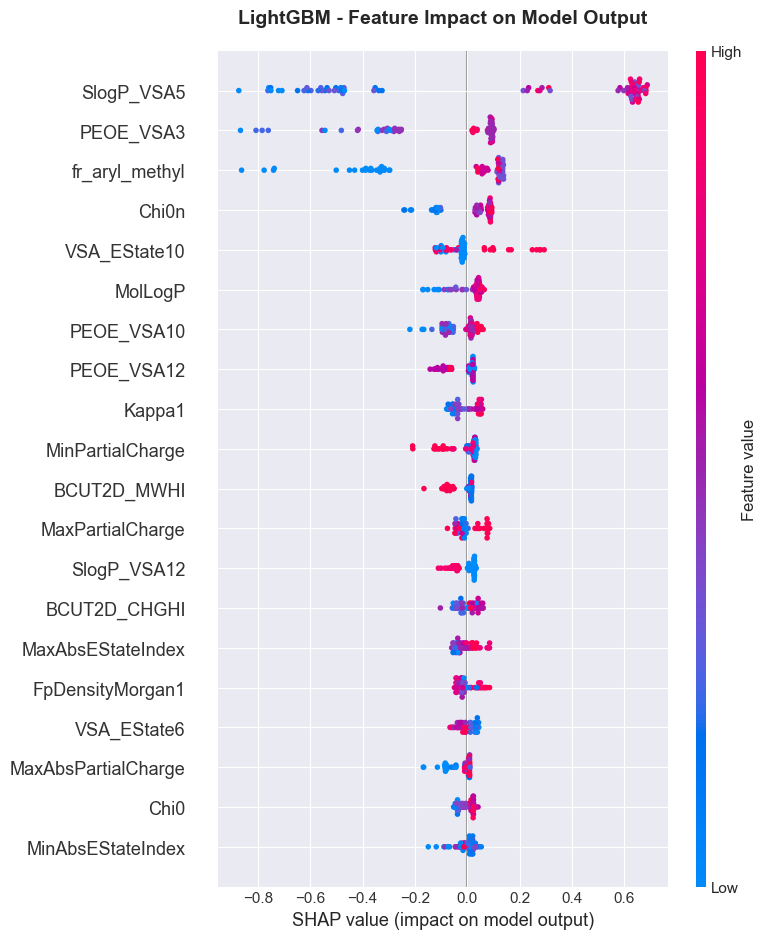

SHAP beeswarm plot saved as 'shap_beeswarm_lgbm.png'


In [53]:
print("Creating SHAP beeswarm plot for LightGBM...")

plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values_lgbm, X_test, feature_names=feature_names,
                  plot_type="dot", show=False, max_display=20)
plt.title('LightGBM - Feature Impact on Model Output', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_beeswarm_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP beeswarm plot saved as 'shap_beeswarm_lgbm.png'")

Creating SHAP bar plot for LightGBM...


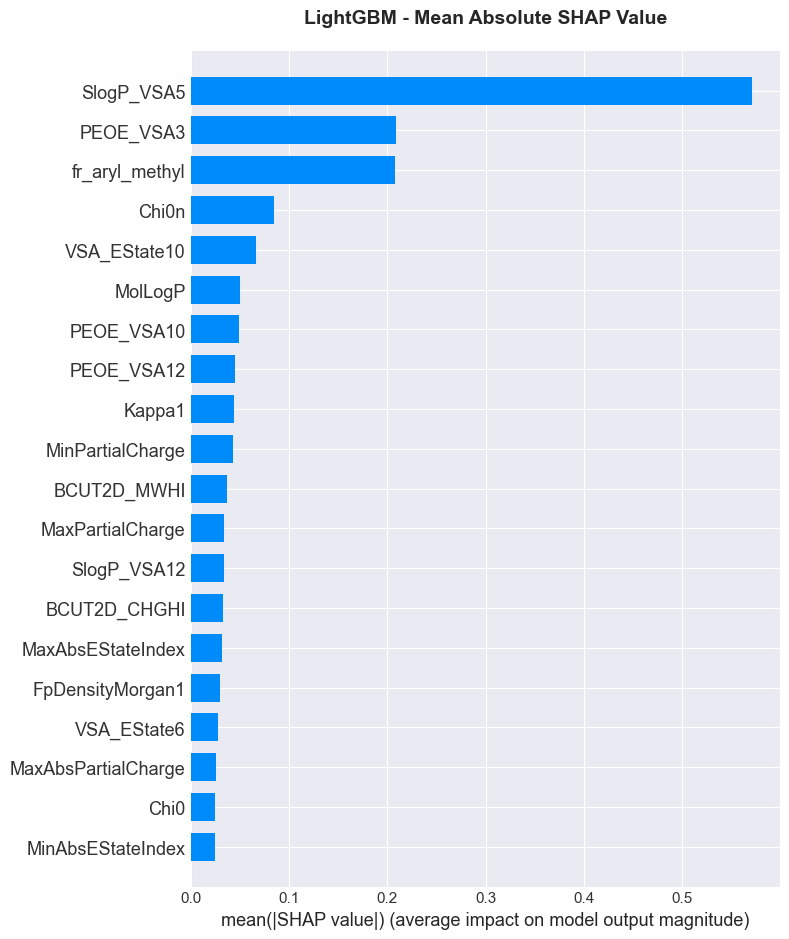

SHAP bar plot saved as 'shap_bar_lgbm.png'


In [54]:
print("Creating SHAP bar plot for LightGBM...")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_lgbm, X_test, feature_names=feature_names,
                  plot_type="bar", show=False, max_display=20)
plt.title('LightGBM - Mean Absolute SHAP Value', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./images/shap_bar_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP bar plot saved as 'shap_bar_lgbm.png'")

Creating SHAP interaction heatmap for LightGBM...


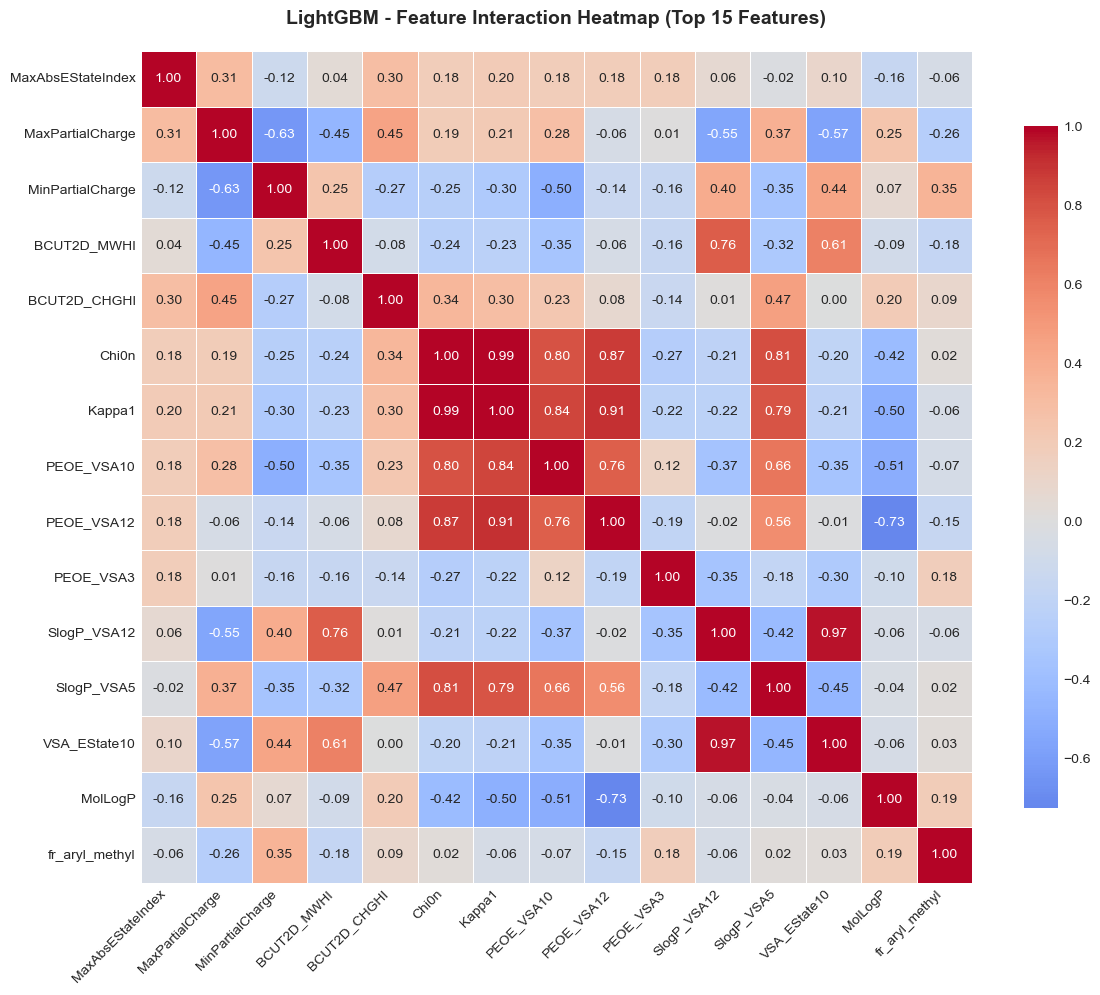

SHAP interaction heatmap saved as 'shap_interaction_heatmap_lgbm.png'


In [55]:
print("Creating SHAP interaction heatmap for LightGBM...")

top_n_features_lgbm = 15
top_features_names_lgbm = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] in shap_importance_lgbm.head(top_n_features_lgbm)['feature'].values]

X_test_df = pd.DataFrame(X_test, columns=feature_names)
top_features_data_lgbm = X_test_df[top_features_names_lgbm]
correlation_matrix_lgbm = top_features_data_lgbm.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_lgbm, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f'LightGBM - Feature Interaction Heatmap (Top {top_n_features_lgbm} Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/shap_interaction_heatmap_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"SHAP interaction heatmap saved as 'shap_interaction_heatmap_lgbm.png'")

# PART 5: Model Comparison

## Comparative Performance Table

In [56]:
comparison_data = {
    'Model': ['Random Forest', 'Decision Tree', 'LightGBM'],
    'R² (Train)': [r2_train, r2_train_dt, r2_train_lgbm],
    'R² (Test)': [r2_test, r2_test_dt, r2_test_lgbm],
    'RMSE (Train)': [rmse_train, rmse_train_dt, rmse_train_lgbm],
    'RMSE (Test)': [rmse_test, rmse_test_dt, rmse_test_lgbm],
    'MAE (Train)': [mae_train, mae_train_dt, mae_train_lgbm],
    'MAE (Test)': [mae_test, mae_test_dt, mae_test_lgbm]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nMODEL COMPARISON - TEST SET PERFORMANCE")
comparison_df


MODEL COMPARISON - TEST SET PERFORMANCE


,Model,R² (Train),R² (Test),RMSE (Train),RMSE (Test),MAE (Train),MAE (Test)
0,Random Forest,0.992172,0.891807,0.139810,0.487182,0.091845,0.356095
1,Decision Tree,0.966511,0.821813,0.289183,0.625213,0.226394,0.432281
2,LightGBM,0.994686,0.871408,0.115190,0.531126,0.049332,0.395364


## Visual Comparison

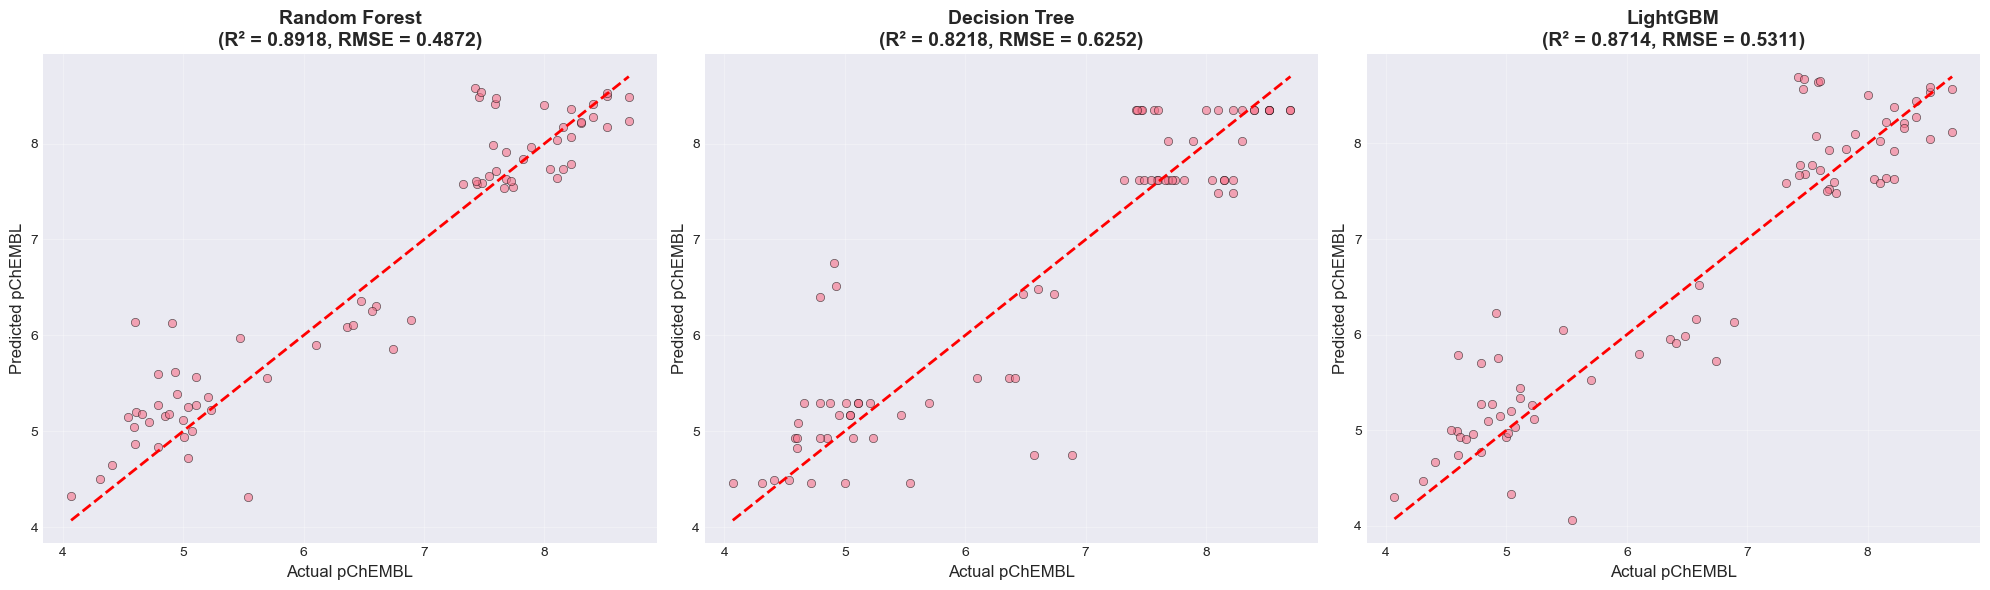

Comparison plot saved as 'model_comparison.png'


In [57]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual pChEMBL', fontsize=12)
axes[0].set_ylabel('Predicted pChEMBL', fontsize=12)
axes[0].set_title(f'Random Forest\n(R² = {r2_test:.4f}, RMSE = {rmse_test:.4f})', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_test_pred_dt, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual pChEMBL', fontsize=12)
axes[1].set_ylabel('Predicted pChEMBL', fontsize=12)
axes[1].set_title(f'Decision Tree\n(R² = {r2_test_dt:.4f}, RMSE = {rmse_test_dt:.4f})', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].scatter(y_test, y_test_pred_lgbm, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual pChEMBL', fontsize=12)
axes[2].set_ylabel('Predicted pChEMBL', fontsize=12)
axes[2].set_title(f'LightGBM\n(R² = {r2_test_lgbm:.4f}, RMSE = {rmse_test_lgbm:.4f})', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved as 'model_comparison.png'")